# Wstęp

Jako temat projektu wybrałem badanie istnienia i stabilności klastra cząstek na podstawie potencjału Morse'a.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

### Funkcja Morse'a

Funkcja Morse'a to potencjał między dwiema cząstkami opisujący energię oddziaływania w zależności od ich wzajemnej odległości. Jest często używana do modelowania interakcji atomowych w fizyce i chemii, szczególnie w kontekście wiązań chemicznych. Potencjał Morse'a ma postać:
$$
V_{ij} = e^{\rho_0 \cdot (1 - r_{ij})} \cdot \left( e^{\rho_0 \cdot (1 - r_{ij})} - 2 \right)
$$
gdzie $r_{ij}$​ to odległość między cząstkami $i$ i $j$, a $ρ_0$​ to parametr określający siłę oddziaływania.

### Całkowita energia Morse'a klastra

Całkowita energia klastra to suma energii Morse'a dla wszystkich możliwych par cząstek w klastrze:
$$
V_M = \sum_{i<j} V_{ij}
$$

In [22]:
rho_values = [3, 6, 10, 14]

def morse_potential(r, rho):
    return np.exp(rho * (1 - r)) * (np.exp(rho * (1 - r)) - 2)

def total_morse_energy(positions, rho):
    distances = pdist(positions)
    energy = np.sum(morse_potential(distances, rho))
    return energy

Celem algorytmów optymalizacji jest znalezienie konfiguracji cząstek, która minimalizuje całkowitą energię Morse'a klastra. Wyniki powinny być podobne do tych uzyskanych przez badaczy w poniższej tabeli:

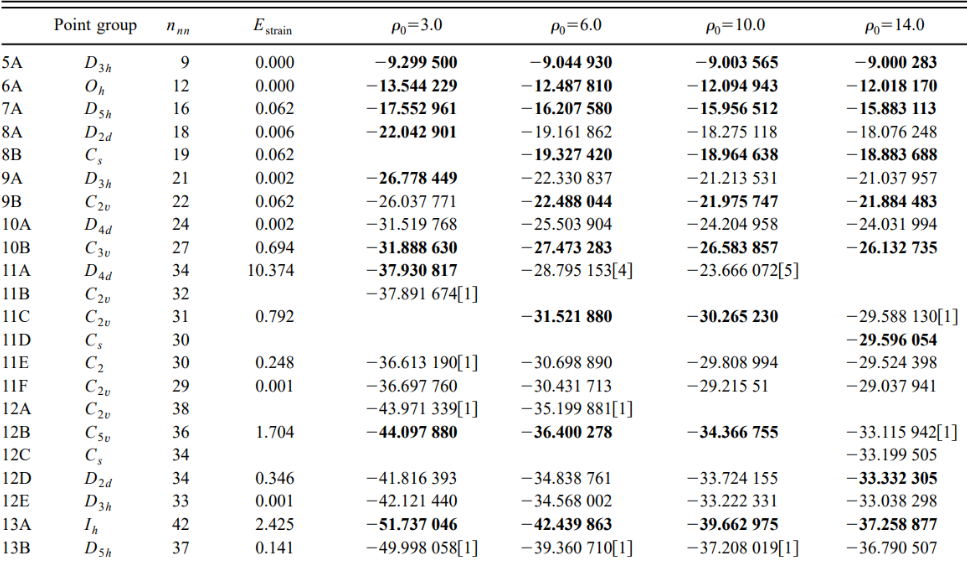

### Algorytm Genetyczny (GA)

Algorytm genetyczny to metoda optymalizacji inspirowana procesem ewolucji biologicznej. Wykorzystuje rodzaj heurystyki przeszukującej przestrzeń alternatywnych rozwiązań problemu w celu wyszukania najlepszych rozwiązań. Główne kroki obejmują:

1. **Inicjalizacja populacji**: Generowanie losowych konfiguracji cząstek.
2. **Ewaluacja fitness**: Obliczanie energii Morse'a dla każdej konfiguracji.
3. **Selekcja**: Wybór najlepszych konfiguracji do reprodukcji.
4. **Krzyżowanie**: Łączenie par konfiguracji w celu wygenerowania nowej populacji.
5. **Mutacja**: Wprowadzanie losowych zmian w konfiguracjach.
5. **Lokalna optymalizacja**: Dodatkowa optymalizacja najlepszych konfiguracji za pomocą metod      gradientowych.

Wewnątrz funkcji local_optimization, definiowana jest funkcja energy_func. Ta funkcja przyjmuje wektor x, przekształca go z powrotem do formy macierzy 3D (gdzie każdy wiersz reprezentuje pozycję jednego atomu), a następnie oblicza i zwraca całkowitą energię klastra za pomocą funkcji total_morse_energy.

Następnie, funkcja minimize z pakietu scipy.optimize jest używana do znalezienia pozycji atomów, które minimalizują energię klastra. Metoda optymalizacji to 'L-BFGS-B', która jest dobrze przystosowana do problemów z ograniczeniami.

In [24]:
# Generowanie losowych początkowych pozycji
def generate_initial_positions(N):
    return np.random.rand(N, 3) * 2  # W przedziale [0,2]

# Lokalna optymalizacja
def local_optimization(positions, rho):
    def energy_func(x):
        return total_morse_energy(x.reshape(-1, 3), rho)
    
    result = minimize(energy_func, positions.flatten(), method='L-BFGS-B', bounds=[(0, 2)] * (3 * len(positions)))
    return result.x.reshape(-1, 3), result.fun

# Algorytm Genetyczny z lokalną optymalizacją
def genetic_algorithm(N, rho, pop_size=300, generations=1500, mutation_rate=0.05):
    population = [generate_initial_positions(N) for _ in range(pop_size)]
    best_solution = None
    best_fitness = float('inf')

    for generation in range(generations):
        fitness = np.array([total_morse_energy(individual, rho) for individual in population])
        best_index = np.argmin(fitness)
        
        if fitness[best_index] < best_fitness:
            best_fitness = fitness[best_index]
            best_solution = population[best_index]

        selected = [population[np.random.choice(np.arange(pop_size))] for _ in range(pop_size)]
        
        children = []
        for i in range(0, pop_size, 2):
            parent1, parent2 = selected[i], selected[i+1]
            crossover_point = np.random.randint(1, N*3-1)
            child1 = np.concatenate([parent1.flatten()[:crossover_point], parent2.flatten()[crossover_point:]]).reshape(N, 3)
            child2 = np.concatenate([parent2.flatten()[:crossover_point], parent1.flatten()[crossover_point:]]).reshape(N, 3)
            children.append(child1)
            children.append(child2)
        
        for child in children:
            if np.random.rand() < mutation_rate:
                idx = np.random.randint(0, N*3)
                child.flatten()[idx] = np.random.rand() * 2
        
        population = children

    best_solution, best_fitness = local_optimization(best_solution, rho)
    return best_solution, best_fitness


### Particle Swarm Optimization (PSO)

PSO to algorytm inspirowany zachowaniem rojów ptaków lub ryb. Główne kroki obejmują:

1. **Inicjalizacja roju**: Generowanie losowych konfiguracji cząstek i prędkości.
2. **Ewaluacja fitness**: Obliczanie energii Morse'a dla każdej konfiguracji.
3. **Aktualizacja prędkości i pozycji**: Dostosowywanie prędkości i pozycji cząstek na podstawie najlepszych wyników indywidualnych i globalnych. Przez określoną liczbę iteracji, dla każdej cząstki w roju, aktualizuje jej prędkość i pozycję na podstawie obecnej prędkości, najlepszej dotychczas znalezionej pozycji przez tę cząstkę (p_best) i najlepszej pozycji znalezionej przez cały rój (g_best).
4. **Lokalna optymalizacja:** Dodatkowa optymalizacja najlepszych konfiguracji za pomocą metod gradientowych.

In [25]:
# Algorytm PSO z lokalną optymalizacją
def pso(N, rho, swarm_size=500, iterations=3000, w=0.3, c1=2.5, c2=2.5):
    positions = [generate_initial_positions(N) for _ in range(swarm_size)]
    velocities = [np.random.rand(N, 3) * 0.1 for _ in range(swarm_size)]
    p_best_positions = positions[:]
    p_best_scores = [total_morse_energy(pos, rho) for pos in positions]
    g_best_position = p_best_positions[np.argmin(p_best_scores)]
    g_best_score = min(p_best_scores)

    for iteration in range(iterations):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (w * velocities[i] + 
                             c1 * r1 * (p_best_positions[i] - positions[i]) + 
                             c2 * r2 * (g_best_position - positions[i]))
            positions[i] += velocities[i]

            fitness = total_morse_energy(positions[i], rho)
            if fitness < p_best_scores[i]:
                p_best_scores[i] = fitness
                p_best_positions[i] = positions[i]
                if fitness < g_best_score:
                    g_best_score = fitness
                    g_best_position = positions[i]

    g_best_position, g_best_score = local_optimization(g_best_position, rho)
    return g_best_position, g_best_score


Parametry $ρ$ określają siłę oddziaływania między cząstkami. Testowane są różne wartości $ρ$ : 3, 6, 10, 14.

In [26]:
# Eksperymenty dla różnych wartości N i rho
N_values = [5, 6, 7, 8]
results_ga = {}
results_pso = {}

for rho in rho_values:
    results_ga[rho] = []
    results_pso[rho] = []
    for N in N_values:
        best_solution_ga, best_fitness_ga = genetic_algorithm(N, rho)
        best_solution_pso, best_fitness_pso = pso(N, rho)
        results_ga[rho].append((N, best_fitness_ga))
        results_pso[rho].append((N, best_fitness_pso))

# Wypisanie wyników
print("Wyniki Algorytmu Genetycznego:")
for rho, results in results_ga.items():
    print(f"rho = {rho}:")
    for N, fitness in results:
        print(f"  N = {N}, VM = {fitness}")

print("\nWyniki Algorytmu PSO:")
for rho, results in results_pso.items():
    print(f"rho = {rho}:")
    for N, fitness in results:
        print(f"  N = {N}, VM = {fitness}")

Wyniki Algorytmu Genetycznego:
rho = 3:
  N = 5, VM = -9.299500493191609
  N = 6, VM = -13.544228773285809
  N = 7, VM = -17.55296100212567
  N = 8, VM = -22.042900783959674
rho = 6:
  N = 5, VM = -9.044930495534869
  N = 6, VM = -12.12803412244603
  N = 7, VM = -15.215747160761113
  N = 8, VM = -18.306022491681787
rho = 10:
  N = 5, VM = -9.003565009701175
  N = 6, VM = -12.009682634160464
  N = 7, VM = -15.015896379357116
  N = 8, VM = -18.0246598574601
rho = 14:
  N = 5, VM = -9.000283374418688
  N = 6, VM = -12.000743639829446
  N = 7, VM = -14.001247643701625
  N = 8, VM = -16.004717163441782

Wyniki Algorytmu PSO:
rho = 3:
  N = 5, VM = -9.299500505321543
  N = 6, VM = -13.544228774836547
  N = 7, VM = -17.276413564823777
  N = 8, VM = -22.042900784136172
rho = 6:
  N = 5, VM = -9.044930495561342
  N = 6, VM = -12.128034122058418
  N = 7, VM = -15.24756706316399
  N = 8, VM = -18.34097945823185
rho = 10:
  N = 5, VM = -9.003565009847035
  N = 6, VM = -12.009682634315459
  N = 7, 

In [27]:
# Wizualizacja najlepszego klastra za pomocą py3Dmol
def visualize_cluster_py3dmol(positions, title):
    mol = py3Dmol.view()
    
    for pos in positions:
        mol.addSphere({'center': {'x': pos[0], 'y': pos[1], 'z': pos[2]}, 'radius': 0.1, 'color': 'blue'})
    
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            mol.addCylinder({'start': {'x': positions[i][0], 'y': positions[i][1], 'z': positions[i][2]},
                             'end': {'x': positions[j][0], 'y': positions[j][1], 'z': positions[j][2]},
                             'radius': 0.02, 'color': 'gray'})

    mol.addSurface(py3Dmol.VDW, {'opacity': 0.3, 'color': 'lightgray'})
    
    mol.setBackgroundColor('white')
    mol.zoomTo()
    mol.show()
    print(title)

# Przykładowa wizualizacja najlepszego klastra dla N=8, rho=6
best_cluster_ga, _ = genetic_algorithm(8, 6)
best_cluster_pso, _ = pso(8, 6)

visualize_cluster_py3dmol(best_cluster_ga, "Best Cluster (GA, N=8, rho=6)")
visualize_cluster_py3dmol(best_cluster_pso, "Best Cluster (PSO, N=8, rho=6)")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Best Cluster (GA, N=8, rho=6)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Best Cluster (PSO, N=8, rho=6)


In [29]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import Delaunay

def visualize_cluster_plotly(positions, title):
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    tri = Delaunay(positions).convex_hull
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=4, color='blue')
    ))
    
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            fig.add_trace(go.Scatter3d(
                x=[positions[i][0], positions[j][0]],
                y=[positions[i][1], positions[j][1]],
                z=[positions[i][2], positions[j][2]],
                mode='lines',
                line=dict(color='gray', width=2)
            ))
    
    fig.add_trace(go.Mesh3d(
        x=x, y=y, z=z,
        i=tri[:, 0], j=tri[:, 1], k=tri[:, 2],
        opacity=0.5,
        color='lightgray'
    ))
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        showlegend=False
    )
    
    fig.show()

# Przykładowa wizualizacja najlepszego klastra dla N=8, rho=6
best_cluster_ga, _ = genetic_algorithm(8, 6)
best_cluster_pso, _ = pso(8, 6)

visualize_cluster_plotly(best_cluster_ga, "Best Cluster (GA, N=8, rho=6)")
visualize_cluster_plotly(best_cluster_pso, "Best Cluster (PSO, N=8, rho=6)")

# Podsumowanie

Kod zawiera zaawansowane metody optymalizacji (GA i PSO) do znalezienia minimalnych energii Morse'a dla różnych konfiguracji klastrów atomowych. Te algorytmy, wspomagane lokalną optymalizacją, dążą do znalezienia optymalnych struktur klastrów, co jest istotne w badaniach nad strukturą materiałów na poziomie atomowym.

Oba algorytmy generują wyniki podobne do tych z tabeli badaczy, nie można jednoznacznie stwierdzić który wypadł lepiej. 
Dla większych wartości parametru rho (np. rho = 14) uzyskane wartości energii były początkowo wyższe od oczekiwanych, co sugeruje trudności w optymalizacji w bardziej złożonych przypadkach. Problem rozwiązałem dodając lokalną optymalizację do obu algorytmów.

### Wyniki sprzed dodania optymalizacji lokalnej:

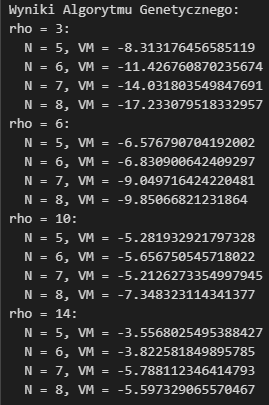          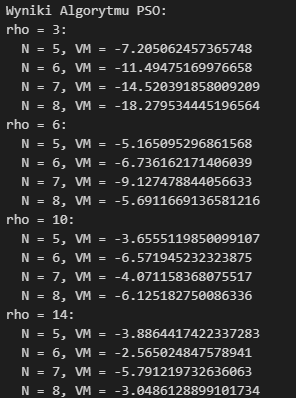